In [28]:
# necessary libraries, functions, and constants
import csv
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from PIL import Image
from sklearn import discriminant_analysis
from sklearn import metrics
from sklearn import model_selection
from sklearn import neighbors

classes = ['ocean', 'ship', 'sky']

# options
oversample = False

# this function taken from:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() * 0.75
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{0:.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

    
def oversample(X, y, cl, largest_class):
    """
    returns new X and y lists with oversampling
    """
    X_new = list(X)
    y_new = list(y)
    
    # first count each class in y
    class_count = y.count(cl)
    obs_add = largest_class - class_count
    print("oversample - %s samples with %s class in y, adding %s observations" % (class_count, cl, obs_add))
    
    # keep adding samples for the class
    obs_added = 0
    class_index = 0
    all_in_class = [i for i, x in enumerate(y) if x == cl ] # => [1, 4, 6], all indexes for the class
    assert len(all_in_class) > 0
    
    # take observations from the class sequentially, looping around when off the end
    while obs_added < obs_add:
        index = all_in_class[class_index]
        
        y_new.append(y[index])
        X_new.append(X[index])
        
        obs_added += 1
        
        class_index += 1
        if class_index >= len(all_in_class):
            class_index = 0
    
    return X_new, y_new


def next_batch(X, y, offset, step):
    """
    returns a batch of observations and new offset, given offset and step
    if the batch will run off the end, loops back around
    """
    X_batch = []
    y_batch = []
    
    assert len(X) == len(y)
    
    if offset + step >= len(X):
        new_offset = offset + step - len(X)
        X_batch = list(X[offset:])
        X_batch.extend(list(X[:new_offset]))
        y_batch = list(y[offset:])
        y_batch.extend(list(y[:new_offset]))
    else:
        new_offset = offset + step
        X_batch = X[offset:offset + step]
        y_batch = y[offset:offset + step]
    
    return X_batch, y_batch, new_offset

In [45]:
# import data from data.csv
y = []
X = []
y_numeric = []

with open('data.csv', 'r') as csvfile:
    data_reader = csv.reader(csvfile, dialect='excel')
    for row in data_reader:
        if len(row) > 0:
            y.append(row[0])
            X_float = [ float(x) for x in row[1:] ]
            X.append(X_float)

# create a y_numeric for use with tensorflow
for obs in y:
    y_numeric.append(classes.index(obs))

assert len(X) == len(y) == len(y_numeric)
    
# how many features?
num_features = len(X[0])
print("%s features" % (num_features))

# count the classes
class_counts = {}
largest_class = "none"
largest_class_count = -1
for cl in classes:
    c = y.count(cl)
    
    if c > largest_class_count:
        largest_class_count = c
        largest_class = cl
    
    class_counts[cl] = c

# raw data stats            
print("Raw observations:")
print("%s observations" % (len(y)))
print("Class counts:")
for cl in class_counts.keys():
    print("%s - %s" % (cl, class_counts[cl]))
    
# if desired, use oversampling for any class that has less than 75% of the observations
# of the largest class
if oversample == True:
    print("\nOversampling enabled")
    print("Largest class is " + largest_class + " with %s observations" % (largest_class_count))
    
    for cl in class_counts.keys():
        if class_counts[cl] < 0.8 * largest_class_count:
            # oversample
            X, y = oversample(X, y, cl, largest_class_count)
    
    class_counts = {}
    for cl in classes:
        class_counts[cl] = y.count(cl)
    
    print("\nObservations after oversampling:")
    for cl in class_counts.keys():
        print("%s - %s" % (cl, class_counts[cl]))



3072 features
Raw observations:
3347 observations
Class counts:
sky - 496
ship - 2347
ocean - 504


# K-Nearest Neighbors
Inputs: number of neighbors, training and test sets

Outputs: accuracy score, confusion matrix

In [31]:
# record metrics for the cross-validated value - n-neighbors
# format of knn_metrics is [index, neighbors, score, confusion matrix]
# score is the mean accuracy and is provided by the score function of the classifier
knn_metrics = pd.DataFrame(columns=('neighbors', 'score', 'confusion matrix'))

# create training and test sets
# first method - evenly split training and test set into two random sets
# randomly select from the original data into even-sized training and test sets
# using training/test set cross-validation, with equally sized training and test sets

# validation sets
# TODO need to cross-validate the size of the train/test sets
test_size = 0.5
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=0)

def knn(k, X_train, y_train, X_test, y_test):
    """
    Performs K-nearest Neighbors with provided parameters, returns a tuple containing
    k, accuracy, precision, confusion matrix
    """
    classifier = neighbors.KNeighborsClassifier(k, 'distance')
    classifier.fit(X_train, y_train)
    
    y_prediction = classifier.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_prediction, labels=classes)
    score = classifier.score(X_test, y_test)
    
    metric = (k, score, cm)
    return metric

max_k = int(math.sqrt(len(X_train)))
print("max k = " + str(max_k))

# TODO - look into parallelizing this
i = 0
for k in range(1, max_k + 1, 10):
    metric = knn(k, X_train, y_train, X_test, y_test)
    if k % 2 == 0:
        print("k = %s, metric = %s" % (k, metric))
    knn_metrics.loc[i] = metric
    i += 1

max k = 40


In [32]:
print(knn_metrics)
print(knn_metrics['score'])

max_accuracy = knn_metrics.loc[knn_metrics['score'].idxmax()]
print("best mean accuracy = %s @ k = %s" % (max_accuracy['score'], max_accuracy['neighbors']))


   neighbors     score                                 confusion matrix
0        1.0  0.755078   [[143, 64, 44], [113, 993, 57], [90, 42, 128]]
1       11.0  0.775388  [[132, 88, 31], [100, 1045, 18], [70, 69, 121]]
2       21.0  0.774791   [[126, 97, 28], [97, 1055, 11], [63, 81, 116]]
3       31.0  0.778973   [[116, 108, 27], [69, 1087, 7], [61, 98, 101]]
0    0.755078
1    0.775388
2    0.774791
3    0.778973
Name: score, dtype: float64
best mean accuracy = 0.778972520908 @ k = 31.0


Normalized confusion matrix
[[ 0.46215139  0.43027888  0.10756972]
 [ 0.05932932  0.93465176  0.00601892]
 [ 0.23461538  0.37692308  0.38846154]]


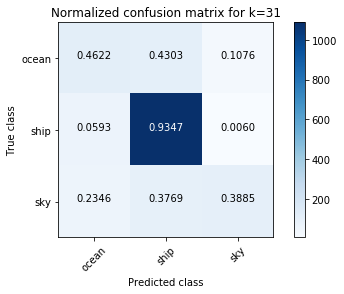

In [33]:
plot_confusion_matrix(max_accuracy['confusion matrix'], 
                      classes, 
                      title='Normalized confusion matrix for k=%s' % (int(max_accuracy['neighbors'])))
plt.show()

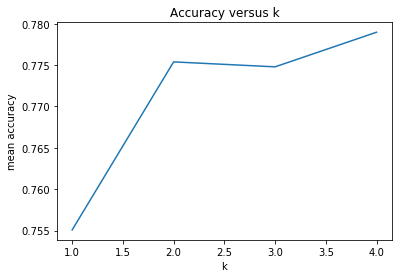

In [34]:
plt.plot(range(1, len(knn_metrics) + 1), knn_metrics['score'], label='accuracy')
plt.title("Accuracy versus k")
plt.xlabel("k")
plt.ylabel("mean accuracy")
plt.show()

# LDA and QDA
Variables: N/A

Output: accuracy score, confusion matrix

C:\Users\jchadwick\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA Results:
accuracy = 0.553166069295
confusion matrix = 
[[104  90  57]
 [256 735 172]
 [ 80  93  87]]
Normalized confusion matrix
[[ 0.41434263  0.35856574  0.22709163]
 [ 0.22012038  0.63198624  0.14789338]
 [ 0.30769231  0.35769231  0.33461538]]


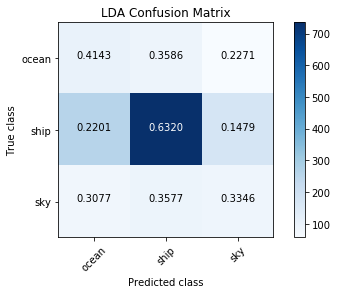

In [40]:
# response has to be numeric for LDA and QDA
y_train_numeric = []
y_test_numeric = []
for cl in y_train:
    y_train_numeric.append(classes.index(cl))

for cl in y_test:
    y_test_numeric.append(classes.index(cl))

# LDA
    
#print(y_train_numeric[:5])
#print(X_train[:5])
classifier = discriminant_analysis.LinearDiscriminantAnalysis()
classifier.fit(X_train, y_train_numeric)

y_prediction = []
y_prediction_num = classifier.predict(X_test)
for pred in y_prediction_num:
    y_prediction.append(classes[pred])

cm = metrics.confusion_matrix(y_test, y_prediction, labels=classes)
accuracy = metrics.accuracy_score(y_test, y_prediction, normalize=True)

print("LDA Results:")
print("accuracy = " + str(accuracy))
print("confusion matrix = ")
print(cm)

plot_confusion_matrix(cm, classes, title="LDA Confusion Matrix")
plt.show()

C:\Users\jchadwick\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA Results:
accuracy = 0.589008363202
confusion matrix = 
[[ 55 166  30]
 [160 891 112]
 [ 49 171  40]]
Normalized confusion matrix
[[ 0.21912351  0.66135458  0.11952191]
 [ 0.13757524  0.7661221   0.09630267]
 [ 0.18846154  0.65769231  0.15384615]]


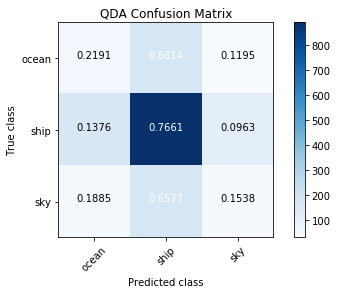

In [41]:
# QDA
classifier = discriminant_analysis.QuadraticDiscriminantAnalysis()
classifier.fit(X_train, y_train_numeric)

y_prediction = []
y_prediction_num = classifier.predict(X_test)
for pred in y_prediction_num:
    y_prediction.append(classes[pred])

cm = metrics.confusion_matrix(y_test, y_prediction, labels=classes)
accuracy = metrics.accuracy_score(y_test, y_prediction, normalize=True)

print("QDA Results:")
print("accuracy = " + str(accuracy))
print("confusion matrix = ")
print(cm)

plot_confusion_matrix(cm, classes, title="QDA Confusion Matrix")
plt.show()

# Softmax Regression (precursor to CNN)

This section is largely adapted from:

https://www.tensorflow.org/get_started/mnist/pros


In [52]:
import tensorflow as tf
sess = tf.InteractiveSession()

# setup inputs
# x has 3072 features since it consists of 32x32 pixels
# y_ is a one-hot multi-dimensional vector the size of the number
# of classes
x = tf.placeholder(tf.float32, [None, num_features])
y_ = tf.placeholder(tf.int32, [None, len(classes)])

# define weights (W) and biases (b)
W = tf.Variable(tf.zeros([num_features, len(classes)]))
b = tf.Variable(tf.zeros([len(classes)]))

# initialize variables
tf.global_variables_initializer().run()

In [53]:
# implement the regression model
model = tf.matmul(x, W) + b

# specify the loss function
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=model))

# use steepest gradient descent to train the model
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [59]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
batch = mnist.train.next_batch(1)

print(batch[0])
print(batch[1])
print(X_train[0])
print(y_train[0])


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         

In [55]:
# now repeatedly run train_step to perform gradient descent
offset = 0
batch_size = 100
for _ in range(1000):
    X_batch, y_batch, offset = next_batch(X_train, y_train_numeric, offset, batch_size)
    sess.run(train_step, feed_dict={x: X_batch, y_: y_batch})

ValueError: Cannot feed value of shape (100,) for Tensor 'Placeholder_17:0', which has shape '(?, 3)'